In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('../'))
from sampling_utils import homogenous_poisson, thinning, return_samples
from hawks import hawkes_calculate, sampleHawkes, plotHawkes
from gumbel import posterior_A_star

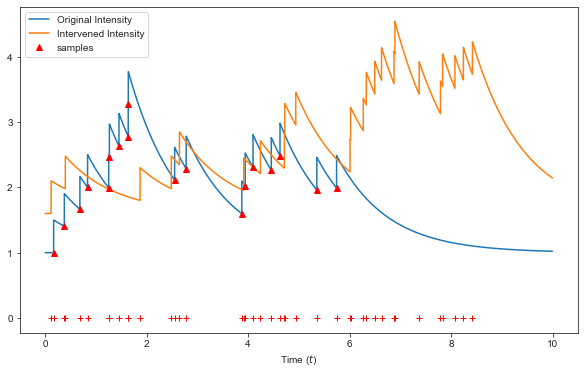

In [17]:
np.random.seed(0)
T = 10
maxNev = 25
lambda_01 = 1
alpha_01 = 0.5
lambda_02 = 1.6
alpha_02 = 0.5
w = 1
plt.figure(figsize=(10, 6))
tev1, tend1, lambdas1 = sampleHawkes(lambda_01, alpha_01, w, T, maxNev)
tev2, tend2, lambdas2 = sampleHawkes(lambda_02, alpha_02, w, T, maxNev)
tvec1, l_t1 = plotHawkes(tev1, lambda_01, alpha_01, w, T, 10000.0, label = 'Original Intensity')
tvec2, l_t2 = plotHawkes(tev2, lambda_02, alpha_02, w, T, 10000.0, label = 'Intervened Intensity')
plt.plot(tev1, lambdas1, 'r^', label = 'samples')
# Labels
plt.xlabel('Time ($t$)')
plt.legend()
plt.ion()
plt.show()

In [18]:
lambda_max = 6
h_observed = tev1
lambda_observed = lambdas1
lambda_bar = lambda x: lambda_max - hawkes_calculate(x, tev1, lambda_01, alpha_01, w)
h_rejected = np.sort(return_samples(lambda_bar, mean=lambda_max, N=25))
lambda_bar_rejected = [lambda_bar(i) for i in h_rejected]

TypeError: hawkes_calculate() takes 1 positional argument but 5 were given

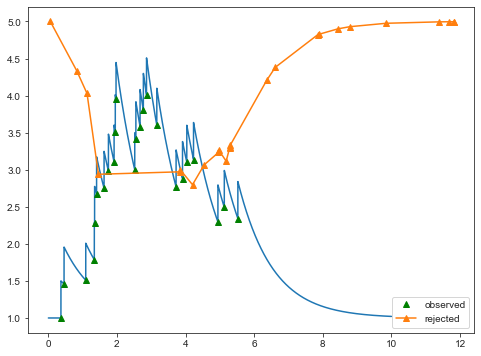

In [58]:
plt.figure(figsize=(8, 6))
plt.plot(tvec1, l_t1)
plt.plot(h_observed, lambdas1, 'g^', label = 'observed')
plt.plot(h_rejected, lambda_bar_rejected, '-^', label = 'rejected')
plt.legend()

In [59]:
sample = []
lambdas = []
indicators = []
all = []
for i in range(len(h_observed)):
    all.append((h_observed[i], lambda_observed[i], True))
for i in range(len(h_rejected)):
    all.append((h_rejected[i], hawkes_calculate(h_rejected[i], tev1, lambda_01, alpha_01, w), False))  # IMPORTANT

h = sorted(all, key=lambda x: x[0])
for i in range(len(h)):
    sample.append(h[i][0])
    lambdas.append(h[i][1])
    indicators.append(h[i][2])

sample = np.array(sample)
lambdas = np.array(lambdas)

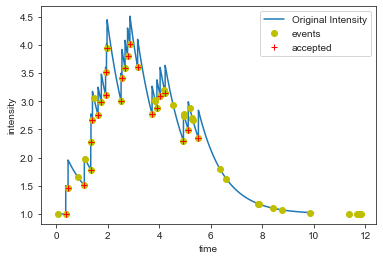

In [60]:
plt.plot(tvec1, l_t1, label = 'Original Intensity')
plt.plot(sample,lambdas, 'oy', label = 'events')
plt.plot(sample[indicators],lambdas[indicators], 'r+', label = 'accepted')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()

In [61]:
counterfactuals = []
counterfactual_indicators = []
k = 100
for i in range(len(sample)):
    ups = []
    for j in range(k):
        post = posterior_A_star(i, lambdas, lambda_max, indicators)
        pp_1 = hawkes_calculate(sample[i], tev2, lambda_02, alpha_02, w)/lambda_max
        pp_0 = 1 - pp_1
        up = np.argmax(np.log(np.array([pp_0, pp_1])) + post)
        ups.append(up)
    if sum(ups)/k > 0.5:
        counterfactuals.append(sample[i])
        counterfactual_indicators.append(True)
    else:
        counterfactual_indicators.append(False)

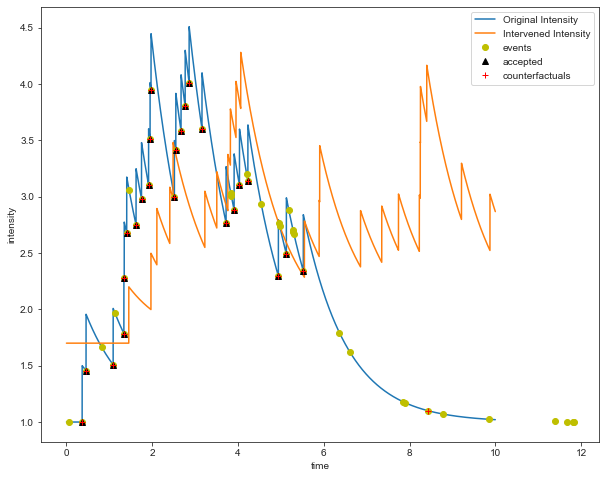

In [62]:
plt.figure(figsize=(10, 8))
plt.plot(tvec1, l_t1, label = 'Original Intensity')
plt.plot(tvec2, l_t2, label = 'Intervened Intensity')
plt.plot(sample,lambdas, 'oy', label = 'events')
plt.plot(sample[indicators],lambdas[indicators], 'k^', label = 'accepted')
plt.plot(counterfactuals, lambdas[counterfactual_indicators], 'r+', label = 'counterfactuals')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()

In [63]:
monotonic = 1
for s in sample:
    if hawkes_calculate(s, tev2, lambda_02, alpha_02, w) >= hawkes_calculate(s, tev1, lambda_01, alpha_01, w) and s in h_observed:
        if s not in counterfactuals:
            print('NOT  MONOTONIC')
            monotonic = 0
for s in sample:
    if hawkes_calculate(s, tev2, lambda_02, alpha_02, w) < hawkes_calculate(s, tev1, lambda_01, alpha_01, w) and s not in h_observed:
        if s in counterfactuals:
            print('NOT  MONOTONIC')
            monotonic = 0
if monotonic == 1:
    print('MONOTONIC')

MONOTONIC
